Mounted at /content/drive


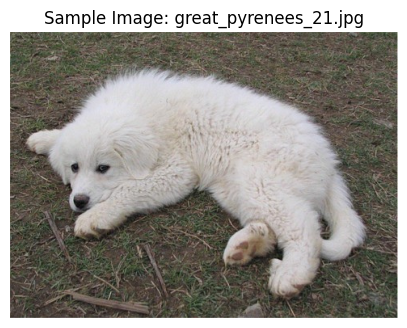

In [3]:
import os
import random
import tarfile
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

# Подключение к Google Диску
from google.colab import drive
drive.mount('/content/drive')

# Путь к архивам на Google Диске
images_tar_path = '/content/drive/MyDrive/Pets/images.tar'
annotations_tar_path = '/content/drive/MyDrive/Pets/annotations.tar'

# Распаковка архивов
with tarfile.open(images_tar_path) as tar:
    tar.extractall(path='/content')

with tarfile.open(annotations_tar_path) as tar:
    tar.extractall(path='/content')

# Проверка: вывод одного случайного изображения
sample_image_path = os.path.join("/content/images", random.choice(os.listdir("/content/images")))
img = load_img(sample_image_path)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"Sample Image: {os.path.basename(sample_image_path)}")
plt.axis('off')
plt.show()

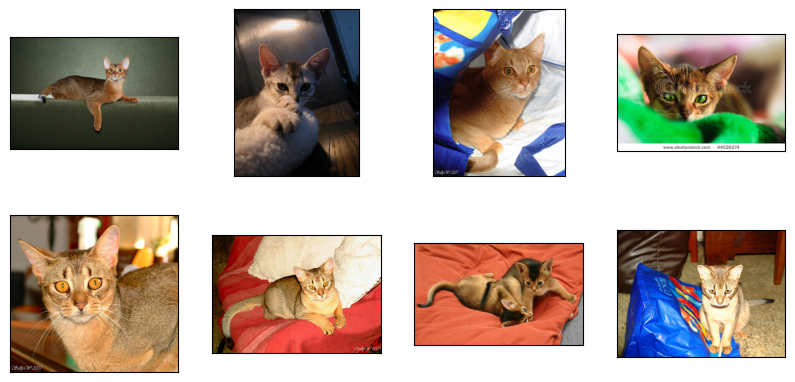

In [4]:

# Предобработка данных
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
])

target_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

# Вывод примеров изображений
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(load_img(input_img_paths[i]))
plt.show()



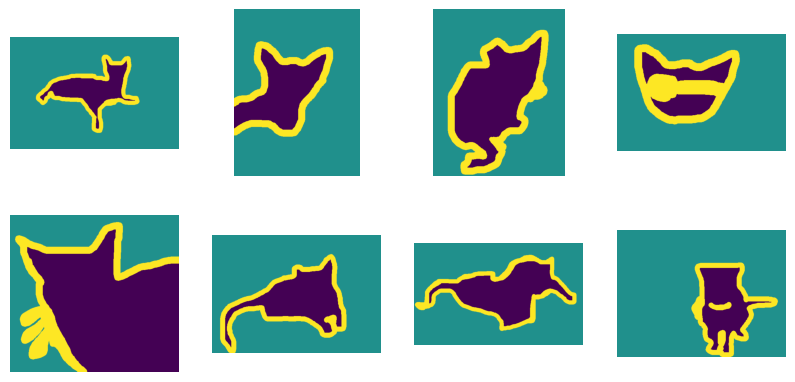

In [5]:
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt

# Вывод примеров масок
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    img = img_to_array(load_img(target_paths[i], color_mode="grayscale"))
    display_target(img)
plt.show()


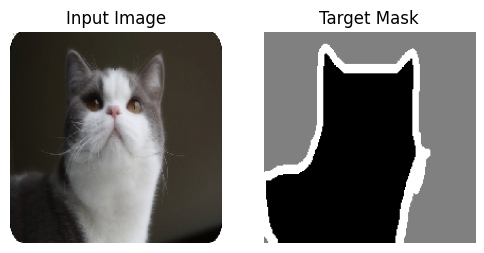

In [6]:
import numpy as np

# Загрузка изображений и масок в массивы
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# Вывод одного примера
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(input_imgs[0].astype("uint8"))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(targets[0].squeeze(), cmap="gray")
plt.title("Target Mask")
plt.axis("off")
plt.show()

In [11]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

# Построение модели автоэнкодера
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # Encoder
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 50, 50, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 200, 200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 387ms/step - loss: 1.0191 - val_loss: 0.8267
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - loss: 0.8347 - val_loss: 0.7802
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - loss: 0.7721 - val_loss: 0.8158
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - loss: 0.7454 - val_loss: 0.6685
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 0.7055 - val_loss: 0.6874
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.6745 - val_loss: 0.8108
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 0.6760 - val_loss: 0.6148
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 0.6533 - val_loss: 0.6491
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 0.6405 - val_loss: 0.5903
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - loss: 0.6255 - val_loss: 0.6108


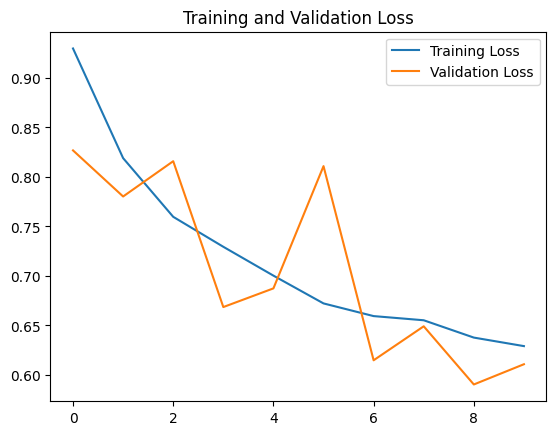

In [13]:
# Компиляция и обучение модели
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

history = model.fit(
    input_imgs[:-1000], targets[:-1000],
    epochs=10,
    batch_size=64,
    validation_data=(input_imgs[-1000:], targets[-1000:])
)

# График ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


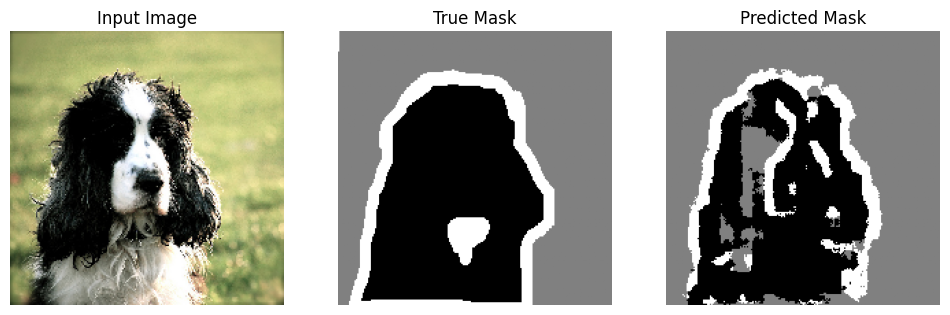

In [16]:

# Проверка сегментации
i = 240

test_image = input_imgs[-1000:][i]
true_mask = targets[-1000:][i]
predicted_mask = model.predict(np.expand_dims(test_image, 0))[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(test_image.astype("uint8"))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(np.argmax(predicted_mask, axis=-1), cmap='gray')
plt.axis("off")
plt.show()
